In [49]:
import tqdm
import hdbscan
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer

all_data = pd.read_csv('Data\submission_and_comments_V3.csv', sep = ";")
data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]

Text(0, 0.5, 'Count')

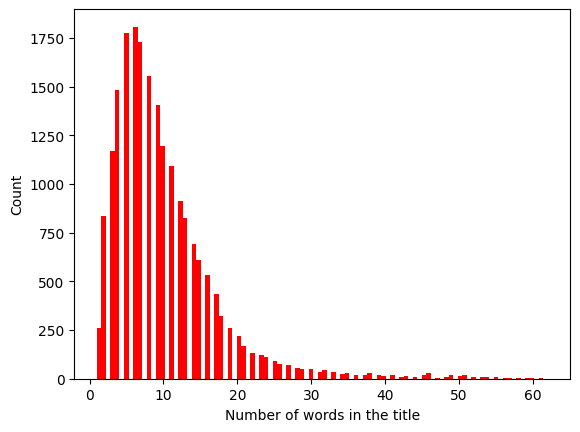

In [8]:
data.submission_title.apply(lambda x: len(x.split(" "))).hist(bins = 100, color = 'r')
plt.grid(None)
plt.xlabel('Number of words in the title')
plt.ylabel('Count')

# 1. Transformer Embedding

In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2')
model.max_seq_length = 60

post_title = data['submission_title'].tolist()
post_title = [post for post in post_title if ((post != "[deleted by user]") and (type(post) == str) and (str(type) != 'nan'))]
emb_title = model.encode(post_title, show_progress_bar = True, normalize_embeddings = False)

Batches: 100%|██████████| 642/642 [01:46<00:00,  6.02it/s]


# 2. PCA

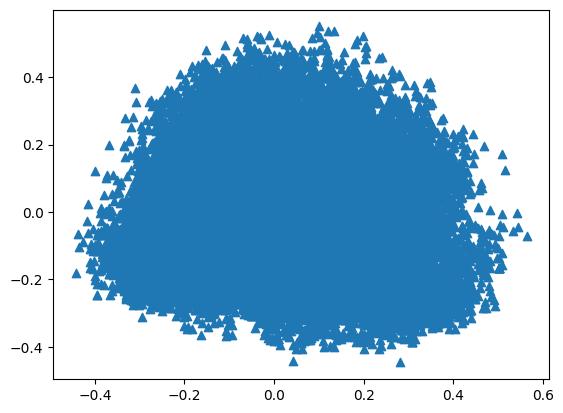

In [17]:
normed_emb = normalize(emb_title)

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(normed_emb)
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

plt.scatter(x0, x1, marker = "^")
plt.show()

# 3. UMAP - Cosine distance

In [19]:
umap_reducer = umap.UMAP(metric = "cosine", verbose = True, n_neighbors = 200, min_dist = 0)
umap_embedding = umap_reducer.fit_transform(emb_title)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_neighbors=200, verbose=True)
Sat May 20 20:55:51 2023 Construct fuzzy simplicial set
Sat May 20 20:55:51 2023 Finding Nearest Neighbors
Sat May 20 20:55:51 2023 Building RP forest with 12 trees
Sat May 20 20:55:56 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sat May 20 20:56:42 2023 Finished Nearest Neighbor Search
Sat May 20 20:56:49 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:17]


Sat May 20 20:57:11 2023 Finished embedding


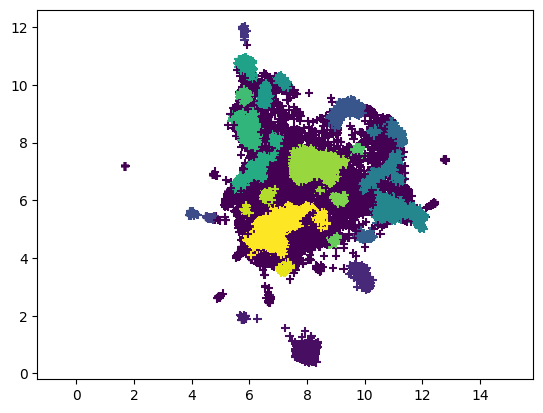

In [43]:
#clustering_model = KMeans(n_clusters = 4, random_state=42)
#clustering_model.fit(umap_embedding)
clustering_model = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size = 100, min_samples = 100)
clustering_model.fit(umap_embedding)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c = clustering_model.labels_, marker = "+")
plt.gca().set_aspect('equal', 'datalim')  

# 4. UMAP - Euclidean Distance

In [22]:
umap_reducer_eucl = umap.UMAP(metric = "euclidean", verbose = True, n_neighbors = 200, min_dist = 0)
umap_embedding_eucl = umap_reducer_eucl.fit_transform(normed_emb)

UMAP(min_dist=0, n_neighbors=200, verbose=True)
Sat May 20 20:58:19 2023 Construct fuzzy simplicial set
Sat May 20 20:58:19 2023 Finding Nearest Neighbors
Sat May 20 20:58:19 2023 Building RP forest with 12 trees
Sat May 20 20:58:19 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sat May 20 20:58:58 2023 Finished Nearest Neighbor Search
Sat May 20 20:59:00 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:15]


Sat May 20 20:59:18 2023 Finished embedding


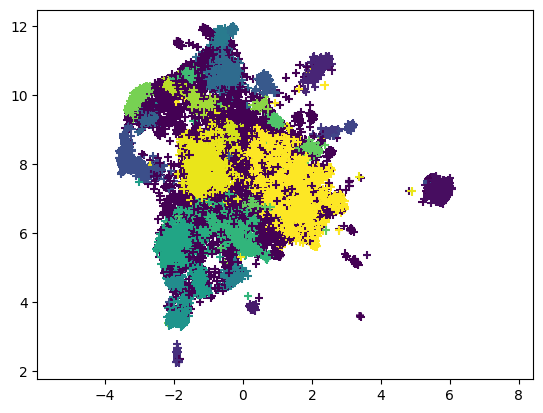

In [42]:
clustering_model = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size = 100, min_samples = 50)
clustering_model.fit(umap_embedding)
plt.scatter(umap_embedding_eucl[:, 0], umap_embedding_eucl[:, 1], c = clustering_model.labels_, marker = "+")
plt.gca().set_aspect('equal', 'datalim')  

# 5. Agglomerative Clustering

In [74]:
agglo_clustering = AgglomerativeClustering(metric = "euclidean", n_clusters = 7)
agglo_clustering.fit(emb_title)

AgglomerativeClustering(metric='euclidean', n_clusters=7)

In [54]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    distance = np.arange(model.children_.shape[0])

    linkage_matrix = np.column_stack(
        [model.children_, distance, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


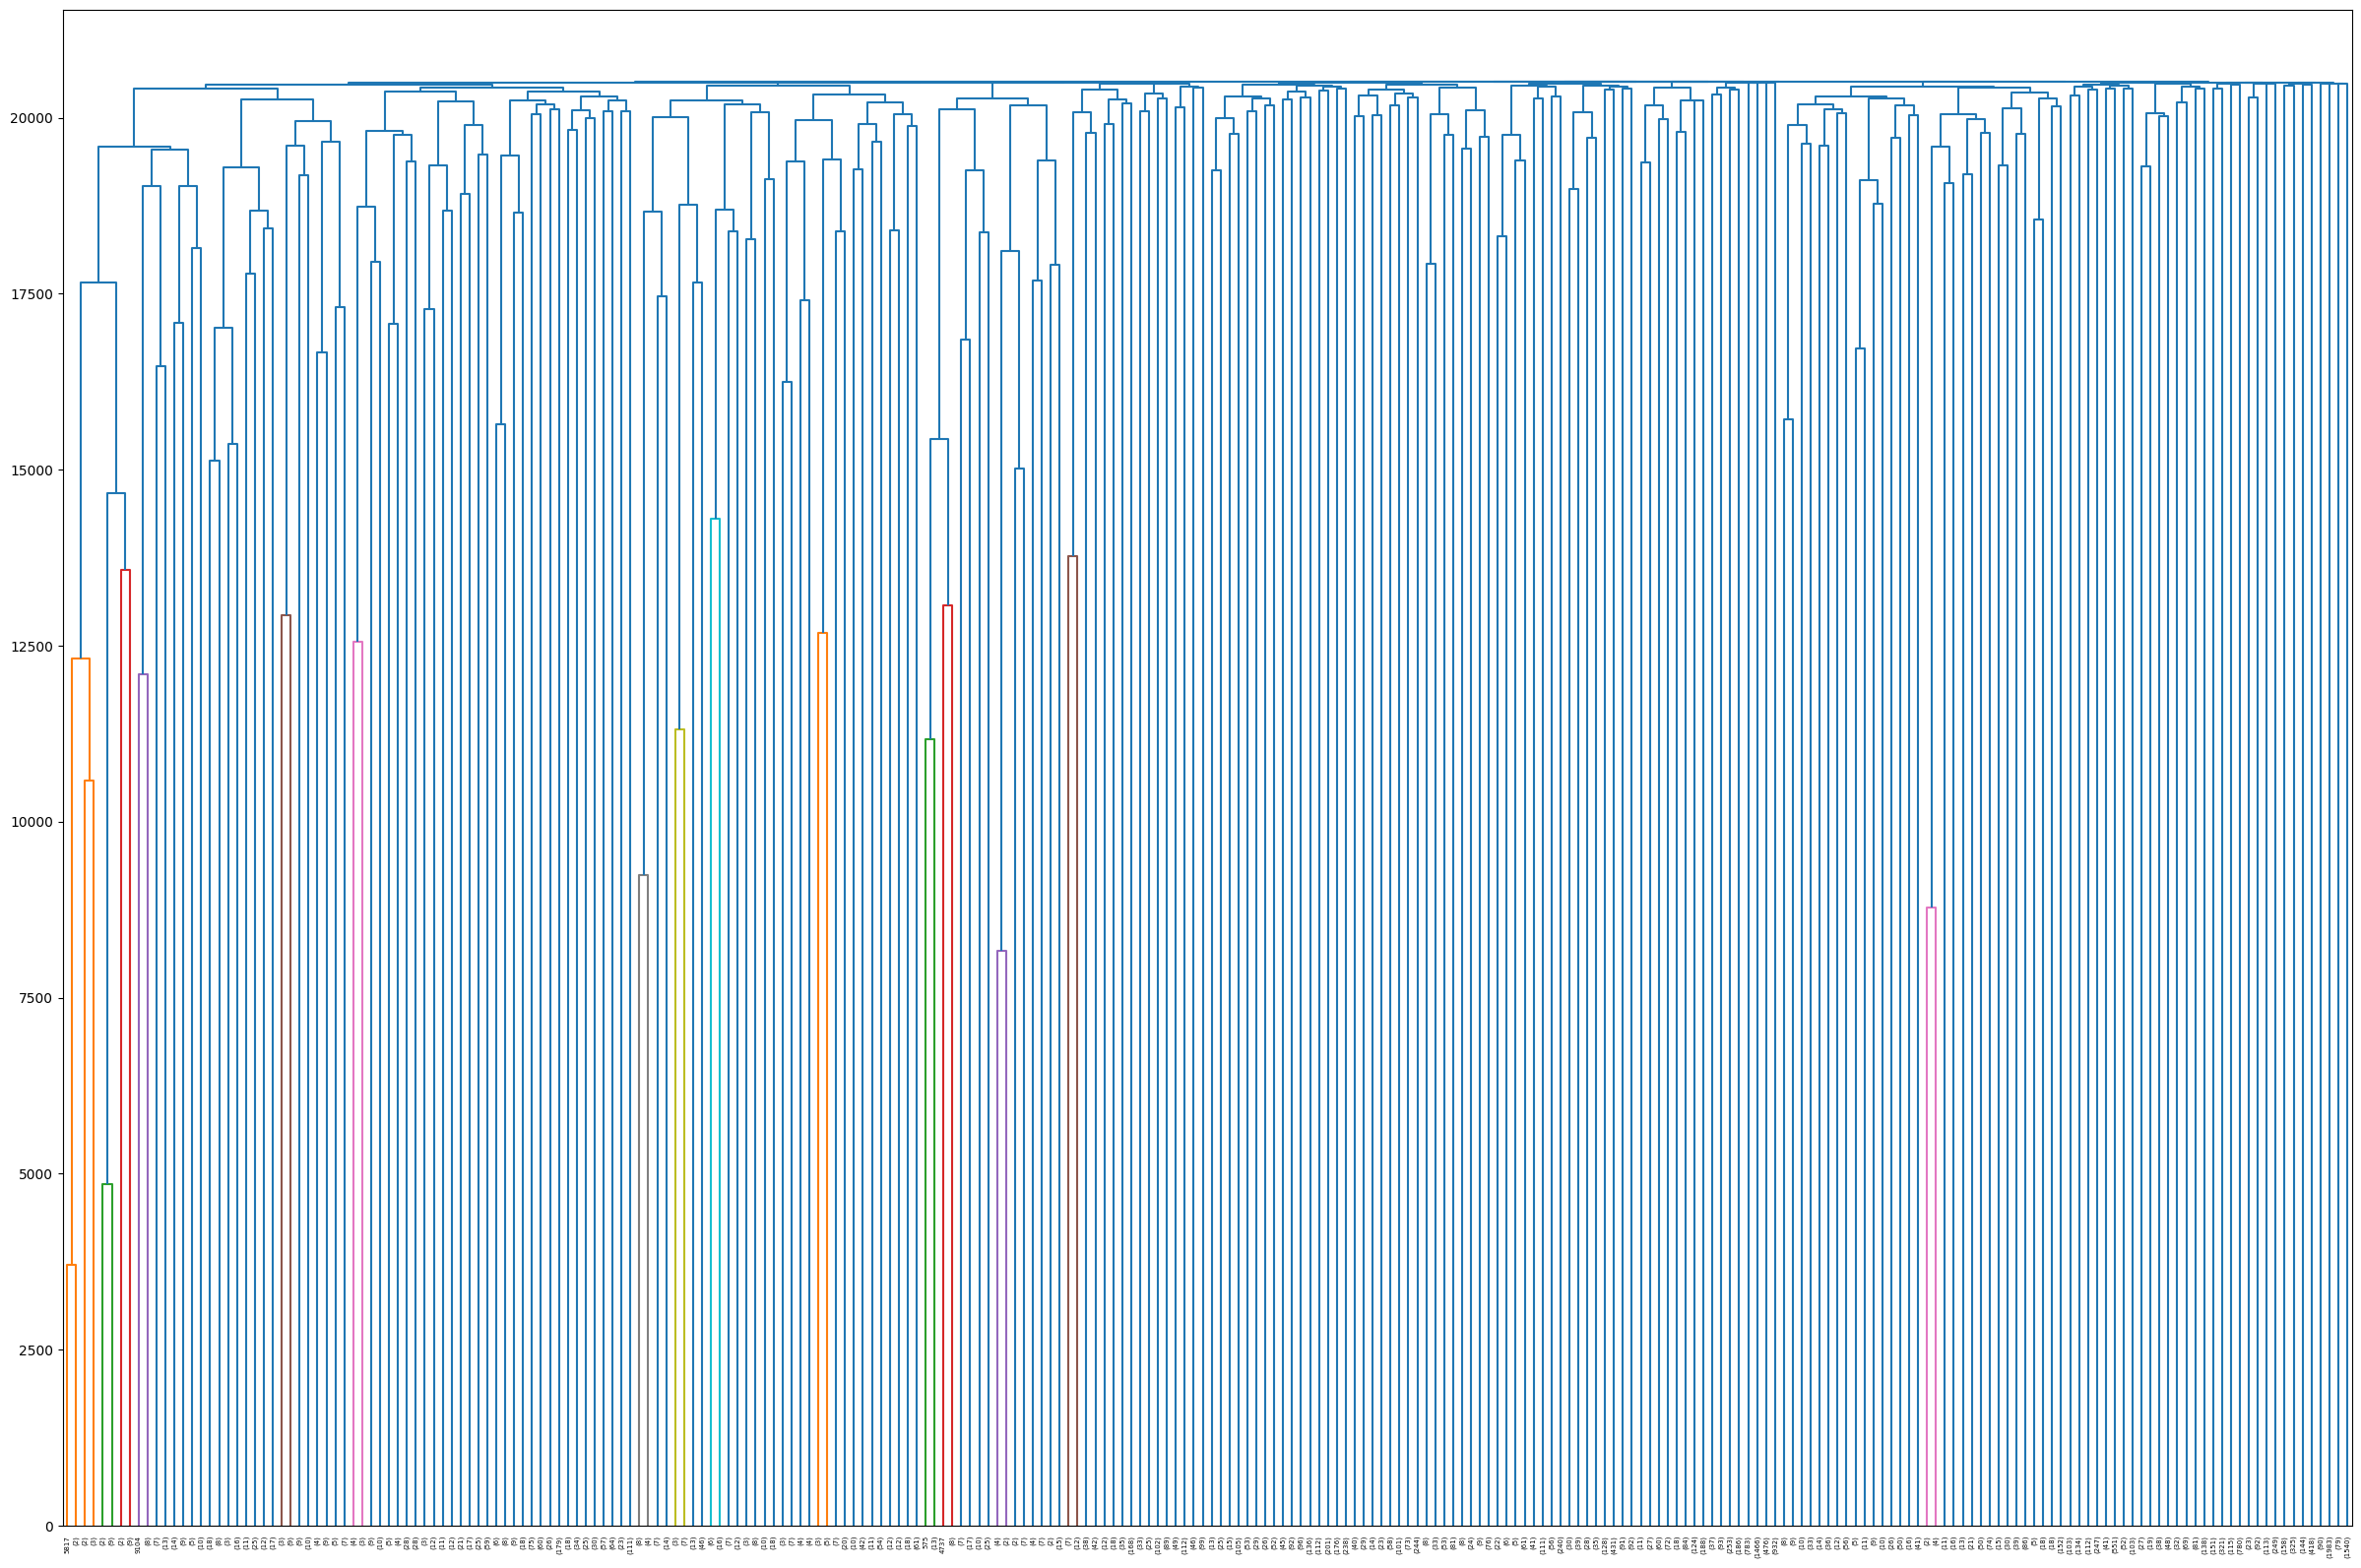

In [73]:
plt.figure(figsize = (30, 20))
plot_dendrogram(agglo_clustering, truncate_mode="level", p=7)